In [63]:
import pandas as pd
import numpy as np
import fiona
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

%matplotlib inline

In [2]:
with fiona.open('data/zonal_stats/ClimateZones/CA_Building_Standards_Climate_Zones_epsg4326.shp') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
features[1]

{'coordinates': [[(-117.37140000022708, 34.2078200000022),
   (-117.36170000038284, 34.20362000033634),
   (-117.35159999971711, 34.203430000388565),
   (-117.33170000036162, 34.203510000018376),
   (-117.33389999946667, 34.196620000218246),
   (-117.33430000031437, 34.192959999780086),
   (-117.3307000002405, 34.18998000017757),
   (-117.31270000022192, 34.18924999989474),
   (-117.31259999976378, 34.183179999637),
   (-117.27300000001297, 34.16887000038066),
   (-117.25260000018952, 34.15816000036249),
   (-117.23930000003793, 34.153280000335734),
   (-117.22810000039912, 34.15273999982848),
   (-117.22810000039091, 34.14631999968745),
   (-117.21329999993624, 34.14476000001897),
   (-117.20350000002922, 34.14594000028508),
   (-117.20130000037405, 34.14159000026895),
   (-117.19180000052195, 34.14058000014042),
   (-117.18970000015521, 34.14758000017767),
   (-117.17879999961406, 34.146350000160886),
   (-117.17769999952648, 34.13913000027949),
   (-117.16960000036777, 34.1385800002

### Convert NetCDF file to multiband GeoTIFF

In [46]:
crs = 'EPSG:4326'

with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    transform, width, height = calculate_default_transform(
        crs, crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': crs,
        'transform': transform,
        'width': width,
        'height': height,
        'driver': 'GTiff',
    })
    # Reproject to geotiff
    with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=src.crs,
                resampling=Resampling.nearest)

(-118.46875, 38.15625)


### Clip GeoTIFF file with polygon

In [77]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif') as src:
    # Clip
    out_image, out_transform = rasterio.mask.mask(src, [features[3]], crop=True, nodata=src.nodata)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                 'height': out_image.shape[1],
                 'width': out_image.shape[2],
                 'transform': out_transform})
    with rasterio.open('data/zonal_stats/clip_wgs84.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

270.9554 281.89972 277.33174261083747


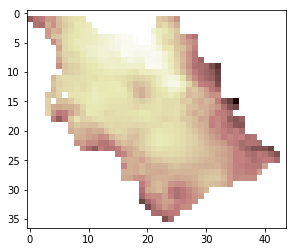

In [90]:
with rasterio.open('data/zonal_stats/clip_wgs84.tif') as src:
    arr = src.read(1, masked=True)
    print(arr.min(), arr.max(), arr.mean())
    plt.imshow(arr, cmap='pink')
    plt.show()  

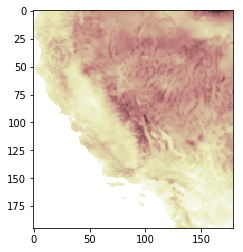

In [103]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    arr = src.read(1, masked=True)
    plt.imshow(arr, cmap='pink')
    plt.show()  